In [7]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import pandas as pd

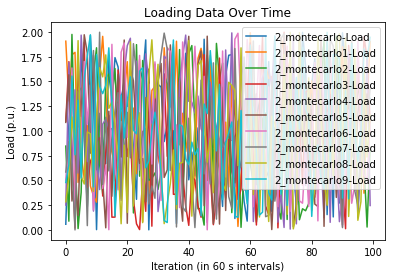

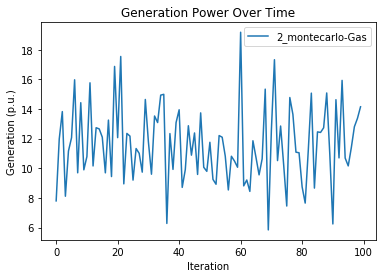

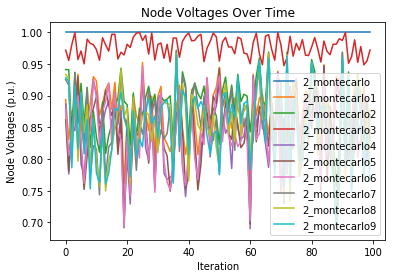

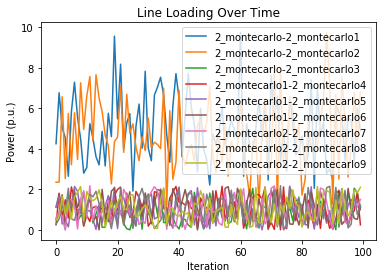

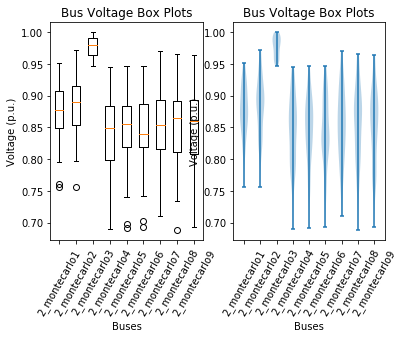

In [8]:
## power flow data
import sys
sys.path.append('../')
from powerflowsim import PowerFlowSim

no_timestamps = 100

pfs = PowerFlowSim(no_timestamps, 'radial', '../_configs/montecarlo10.json')
pfs.nrPfSim(showall = True)

lpf = {'data': pfs.nodeloads,
       'target': pfs.nodevoltages}

mlpf, nlpf = lpf['target'].shape[0], lpf['target'].shape[1]

lpf['data_pb'] = np.c_[np.ones((mlpf, 1)), lpf['data']]
#print(lpf['data'].shape, lpf['data_pb'].shape, lpf['target'].shape)

In [9]:
# power flow theta calculation
Xlpf = tf.constant(lpf['data_pb'], dtype = tf.float32, name = "Xlpf")
ylpf = tf.constant(lpf['target'], dtype = tf.float32, name = "ylpf") 
XTlpf = tf.transpose(Xlpf)
thetalpf = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XTlpf, Xlpf)), XTlpf), ylpf)

In [10]:
with tf.Session() as sess:
    thetalpf_value = thetalpf.eval()
#print(thetalpf_value)

lpf mse:  4.140875697455883e-05


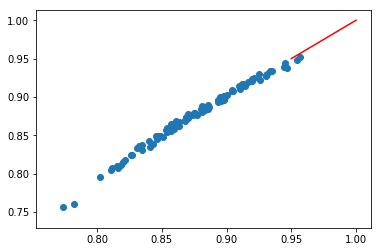

In [11]:
## power flow
biaslpf = []
for i in range(lpf['target'].shape[0]):
    biaslpf.append(thetalpf_value[0])
biaslpf = np.array(biaslpf)

predlpf = np.dot(lpf['data'], thetalpf_value[1:].T) + biaslpf
mselpf = np.mean((predlpf.T[1:].T - lpf['target'].T[1:].T)**2)
print('lpf mse: ', mselpf)

plt.scatter(predlpf.T[1], lpf['target'].T[1]) 
_ = plt.plot([0.95, 1.0], [0.95, 1.0], 'r')
plt.show()